# Diabetes Classification

## Overview
This project uses machine learning classification algorithms to predict whether a person has diabetes, as well as infer what are some of the most important features related to diabetes. A model built using CDC survey data from 2015 predicts whether a person has diabetes with a __ accuracy. The model determined ______ to be the most important features in predicting diabetes. This information can be used to inform guidance for future public health efforts.

## Business Understanding
The local health department is concerned with the current level of diabetes in their community. They need a tool they can deploy to help predict who in the community is diabetic or likely to become diabetic.

## Data Understanding

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.feature_selection import RFE, RFECV

In [2]:
df = pd.read_csv('diabetes_binary_health_indicators_BRFSS2015.csv')
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [4]:
df.describe()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.139333,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.346294,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


In [5]:
#class imbalance
df.Diabetes_binary.value_counts(normalize=True)

0.0    0.860667
1.0    0.139333
Name: Diabetes_binary, dtype: float64

## Data Preparation

In [6]:
#convert categorical variables into dummy variables
categoricals = ['GenHlth', 'Age', 'Education', 'Income']
categorical_df = df[categoricals].astype("category")
dummies = pd.get_dummies(categorical_df , drop_first=True)

In [7]:
df.drop(categoricals, axis=1, inplace=True)
df = pd.concat([df, dummies], axis=1)

In [8]:
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,Education_4.0,Education_5.0,Education_6.0,Income_2.0,Income_3.0,Income_4.0,Income_5.0,Income_6.0,Income_7.0,Income_8.0
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1,0,0,0,0,0,0,0,0,1
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,0,1,0,0,0,1,0,0,0,0


In [9]:
#Split the data
y = df['Diabetes_binary']
X = df.drop('Diabetes_binary', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [10]:
#scaling
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [11]:
#class balancing
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train_scaled, y_train) 

In [12]:
y_train_resampled.value_counts()

1.0    163816
0.0    163816
Name: Diabetes_binary, dtype: int64

## Classification Modeling

### Logitic Regression

In [47]:
#without resampling
logreg_1 = LogisticRegression(fit_intercept=False)

logreg_1_baseline_results  = cross_validate(logreg_1, X_train_scaled, y_train,
                                  scoring=('accuracy', 'recall'))

average_scores(logreg_1_baseline_results)

fit_time: 0.6167516708374023
score_time: 0.02075047492980957
test_accuracy: 0.649721433827394
test_recall: 0.8601193525568581


In [13]:
#with resampling
logreg = LogisticRegression(fit_intercept=False)

logreg_baseline_results  = cross_validate(logreg, X_train_resampled, y_train_resampled,
                                  scoring=('accuracy', 'recall'))

logreg_baseline_results

{'fit_time': array([1.47666502, 1.33537173, 1.21177864, 1.46605706, 0.94345474]),
 'score_time': array([0.041888  , 0.03291202, 0.03593302, 0.03390479, 0.03191018]),
 'test_accuracy': array([0.73554413, 0.7398477 , 0.74202607, 0.74333852, 0.74353692]),
 'test_recall': array([0.89390471, 0.90767306, 0.90907426, 0.90910478, 0.91102768])}

In [19]:
def average_scores(results):
    average_scores = {}
    for key, value in results.items():
        print(key+':', np.mean(value))

In [21]:
average_scores(logreg_baseline_results)

fit_time: 1.286665439605713
score_time: 0.03530960083007813
test_accuracy: 0.7408586655928235
test_recall: 0.9061568984949133


### Random Forest

In [22]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)

forest_baseline_results  = cross_validate(forest, X_train_resampled, y_train_resampled,
                                  scoring=('accuracy', 'recall'))


{'fit_time': array([10.62560058, 10.38621163, 10.22068214, 10.072083  ,  9.46968985]),
 'score_time': array([0.48373675, 0.5186069 , 0.47871971, 0.44683218, 0.42386603]),
 'test_accuracy': array([0.7306759 , 0.81793764, 0.8216891 , 0.82257425, 0.82019351]),
 'test_recall': array([0.65824253, 0.86030399, 0.8683576 , 0.87198974, 0.8628636 ])}

In [23]:
average_scores(forest_baseline_results)

fit_time: 10.154853439331054
score_time: 0.47035231590271
test_accuracy: 0.8026140810867485
test_recall: 0.8243514922077211


### XGBoost

In [24]:
xgb = XGBClassifier()

xgb_baseline_results  = cross_validate(xgb, X_train_resampled, y_train_resampled,
                                  scoring=('accuracy', 'recall'))


In [25]:
average_scores(xgb_baseline_results)

fit_time: 7.0545220375061035
score_time: 0.1529911518096924
test_accuracy: 0.902092070836771
test_recall: 0.8356377833496851


### XGBoost Hyperparameter Tuning

In [20]:
xgb_param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

In [23]:
grid_xgb = GridSearchCV(xgb, xgb_param_grid, scoring=['accuracy', 'recall'],
                        cv=3, n_jobs=1, refit='accuracy')
grid_xgb.fit(X_train_resampled, y_train_resampled)

best_parameters = grid_xgb.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 6
min_child_weight: 1
n_estimators: 100
subsample: 0.7


In [30]:
print('Accuracy: ', grid_xgb.cv_results_['mean_test_accuracy'].mean())
print('Recall: ', grid_xgb.cv_results_['mean_test_recall'].mean())

Accuracy:  0.8927129581025894
Recall:  0.8329142059837911


### Logistic Regression Hyperparameter Tuning

In [ ]:
logreg_param_grid = {

### Feature Selection

In [32]:
selector = RFECV(logreg,cv=5)
selector = selector.fit(X_train_resampled, y_train_resampled)

In [37]:
selector.support_.shape

(45,)

In [39]:
for i in range(len(X_train.columns)):
    print(X_train.columns[i],':', selector.support_[i])

HighBP : True
HighChol : True
CholCheck : True
BMI : True
Smoker : True
Stroke : True
HeartDiseaseorAttack : True
PhysActivity : True
Fruits : False
Veggies : True
HvyAlcoholConsump : True
AnyHealthcare : True
NoDocbcCost : True
MentHlth : True
PhysHlth : True
DiffWalk : True
Sex : True
GenHlth_2.0 : True
GenHlth_3.0 : True
GenHlth_4.0 : True
GenHlth_5.0 : True
Age_2.0 : True
Age_3.0 : True
Age_4.0 : True
Age_5.0 : True
Age_6.0 : True
Age_7.0 : True
Age_8.0 : True
Age_9.0 : True
Age_10.0 : True
Age_11.0 : True
Age_12.0 : True
Age_13.0 : True
Education_2.0 : False
Education_3.0 : True
Education_4.0 : True
Education_5.0 : True
Education_6.0 : True
Income_2.0 : True
Income_3.0 : True
Income_4.0 : True
Income_5.0 : True
Income_6.0 : True
Income_7.0 : True
Income_8.0 : True


In [40]:
X_train_selected = selector.transform(X_train_resampled)

In [43]:
logreg_2 = LogisticRegression(fit_intercept=False)

logreg_2_baseline_results  = cross_validate(logreg_2, X_train_selected, y_train_resampled,
                                  scoring=('accuracy', 'recall'))


In [44]:
average_scores(logreg_2_baseline_results)

fit_time: 0.9416869640350342
score_time: 0.03151559829711914
test_accuracy: 0.7408769783285575
test_recall: 0.9060897497632421


## Final Model Evaluation

In [47]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

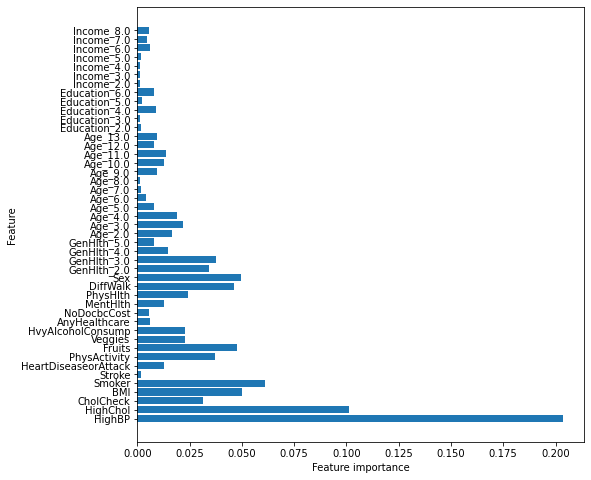

In [48]:
plot_feature_importances(xgb)

## Conclusions

## Next Steps